In [1]:
import geopandas as gpd

import json
from shapely.geometry import shape, Point
import seaborn as sns
import numpy as np
import sympy as sp
import pandas as pd
from math import cos, asin, sqrt
import matplotlib.pyplot as plt
import random
import math
import sys
import copy
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Function to map tabular data to speed using distance between points
def RealSpeed(d,t):
    try:
        return float(d/t*3600.)
    except:
        return None

# Euclidean distance
def distance(lat1, lon1 ,lat2 , lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a)) #2*R*asin...  

sns.set()
sns.set_palette("BuGn_r")


In [2]:
!pip install geopandas

In [3]:
def WriteRoute(Next,init,route):
    route.append(init)
    if Next[init] in Next.keys():
        
        return WriteRoute(Next,Next[init],route)
    else:
        return route

In [4]:
class MyNode:
    def __init__(self):
        self.ID_patient=None
        self.ID_node=None
        self.st_time=None
        self.serv_time=None
        self.type_serv=None
        self.in_neighbors=[]
        self.out_neighbors=[]

    def imprimir(self):
        print("Patient ID:",self.ID_patient)
        print("st time:",self.st_time)
        print("serv time:",self.serv_time)
        print("Follow:",self.in_neighbors)
        print("Coming:",self.out_neighbors)
        print("Node ID:",self.ID_node)
    
    def imprimirLineal(self):
         print(self.ID_patient,self.st_time/3600,self.serv_time/3600)

In [5]:
def FindMiddlePoints(mus,T,draw=False):
    a=np.array([(1/2.*n) for n in range(2*T+1)])
    tau=sp.symbols('tau_0:24')
    t=sp.Symbol('t')
    E=[]
    for N in range(0,T):
        if N>0 and N<T-1:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        elif N==0:
            y1=((tau[N]-tau[T-1]))/(a[2*N+1]-(-a[2*N+1]))*(t-(-a[2*N+1]))+tau[T-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)        
        else:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[0]-tau[N]))/(a[2*N+1]+1-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        

    salida=sp.linsolve(E, (tau))
    #print(salida)
    results=next(iter(salida))
    
    
    if draw:
        plt.figure(figsize=(10, 5))
        plt.bar([0.5+i for i in range(T)], mus, label="Predicted hourly travel time", width=0.95, align='center',color='lightgray')
        plt.plot([0.5+i for i in range(T)],results,label="Interpolation")
        plt.xlabel('Hour')
        plt.ylabel(r'Travel Time (s)')
        plt.legend(prop={'size': 8})
        plt.savefig('./Images/Middle_points_reg.pdf')
        plt.show()
    
    results=[int(i) for i in results]
    return results

In [6]:
def FindMiddlePointsSymbol(T,draw=False):
    a=np.array([(1/2.*n) for n in range(2*T+1)])
    tau=sp.symbols(str('tau_0:')+str(T))
    t=sp.Symbol('t')
    mus=sp.symbols('u_0:24')
    E=[]
    for N in range(0,T):
        if N>0 and N<T-1:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        elif N==0:
            y1=((tau[N]-tau[T-1]))/(a[2*N+1]-(-a[2*N+1]))*(t-(-a[2*N+1]))+tau[T-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)        
        else:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[0]-tau[N]))/(a[2*N+1]+1-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        

    salida=sp.linsolve(E, (tau))
    #print(salida)
    results=next(iter(salida))
    
    
    if draw:
        plt.figure(figsize=(10, 5))
        plt.bar([0.5+i for i in range(T)], mus, label="Predicted hourly travel time", width=0.95, align='center',color='lightgray')
        plt.plot([0.5+i for i in range(T)],results,label="Interpolation")
        plt.xlabel('Hour')
        plt.ylabel(r'Travel Time (s)')
        plt.legend(prop={'size': 8})
        plt.savefig('./Images/Middle_points_reg.pdf')
        plt.show()
    
    #results=[int(i) for i in results]
    return results



In [7]:
mus=FindMiddlePointsSymbol(24,False)
u=sp.symbols('u_0:24')
mus[0].subs([(u[i],10*i) for i in range(24)])

-49.7056245218898

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


33.47520000560799


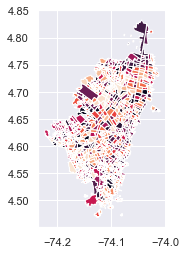

In [8]:
filename="./Input_Data/output_distances_22_8_18_1.csv"#sys.argv[1]

    
    
datos=pd.DataFrame(pd.read_csv("./Input_Data/bogota-cadastral-2019-3-OnlyWeekdays-HourlyAggregate.csv"))
#~ datos=pd.concat([datos1,datos2],keys=['2017-4', '2018-1'])
#print(datos)

dictDistances=pd.DataFrame(pd.read_csv(filename,header=None))
dictDistances=dictDistances.to_dict()

print(dictDistances[1][2])

data=gpd.read_file('./Input_Data/bogota_geo.json')
    
with open('./Input_Data/limites_geojson.json') as f:
	data_lims = json.load(f)   

data=data[data.scatipo.eq(0)]

data.plot(column='cartodb_id')
plt.savefig('world.pdf')


localidades=gpd.read_file('./Input_Data/Bog-poligonos-localidades.geojson')

In [9]:
posx={}
posy={}
for index, row in data.iterrows():
    try:
        posx[row['cartodb_id']],posy[row['cartodb_id']]=shape(row['geometry']).representative_point().xy[0][0],shape(row['geometry']).representative_point().xy[1][0]
    except:
        #print(row['cartodb_id'])
        pass
    #print(shape(row['geometry']).representative_point().xy[0][0],shape(row['geometry']).representative_point().xy[1][0])

TopologyException: Input geom 1 is invalid: Self-intersection at or near point -74.093562714285724 4.5682967142857134 at -74.093562714285724 4.5682967142857134
TopologyException: Input geom 1 is invalid: Self-intersection at or near point -74.093562714285724 4.5682967142857134 at -74.093562714285724 4.5682967142857134


In [10]:
# Adding new columns to the dataframe containg the travel times as read from Uber datafile.
datos["CoorXOrigen"]=datos["sourceid"].map(posx)
datos["CoorYOrigen"]=datos["sourceid"].map(posy)
datos["CoorXDestino"]=datos["dstid"].map(posx)
datos["CoorYDestino"]=datos["dstid"].map(posy)
datos=datos.dropna()

In [11]:
datos=pd.DataFrame(datos)
#print(datos.dtypes)
df=pd.DataFrame({"CoorXOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorXOrigen, "CoorYOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorYOrigen, \
                "CoorXDestino":datos.loc[datos.sourceid!=datos.dstid].CoorXDestino, "CoorYDestino":datos.loc[datos.sourceid!=datos.dstid].CoorYDestino,\
               "horadeldia":datos.loc[datos.sourceid!=datos.dstid].hod, "tiempo_hora":datos.loc[datos.sourceid!=datos.dstid].mean_travel_time})

"""datos=pd.DataFrame(datos)
#print(datos.dtypes)
df=pd.DataFrame({"CoorXOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorXOrigen, "CoorYOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorYOrigen, \
                "CoorXDestino":datos.loc[datos.sourceid!=datos.dstid].CoorXDestino, "CoorYDestino":datos.loc[datos.sourceid!=datos.dstid].CoorYDestino,\
               "horadeldia":datos.loc[datos.sourceid!=datos.dstid].hod,  , "tiempo_hora":datos.loc[datos.sourceid!=datos.dstid].mean_travel_time})"""

#df=pd.DataFrame({"CoorXOrigen":datos["CoorXOrigen"], "CoorYOrigen":datos["CoorYOrigen"], \
#                 "CoorXDestino":datos["CoorXDestino"], "CoorYDestino":datos["CoorYDestino"],\
#                "horadeldia":datos["hod"], "tiempo_hora":datos["mean_travel_time"]})

cols=["CoorXOrigen","CoorYOrigen","CoorXDestino", "CoorYDestino","horadeldia","tiempo_hora"]
df.reindex(cols)
display(df)

#df=pd.DataFrame({"CoorXOrigen":datos["CoorXOrigen"], "CoorYOrigen":datos["CoorYOrigen"], \
#                 "CoorXDestino":datos["CoorXDestino"], "CoorYDestino":datos["CoorYDestino"],\
#                "horadeldia":datos["hod"], "tiempo_hora":datos["mean_travel_time"]})

cols=["CoorXOrigen","CoorYOrigen","CoorXDestino", "CoorYDestino","horadeldia","tiempo_hora"]
df.reindex(cols)
display(df)

,CoorXOrigen,CoorYOrigen,CoorXDestino,CoorYDestino,horadeldia,tiempo_hora
0,-74.099623,4.686262,-74.087588,4.721148,10,1282.33
3,-74.033439,4.684943,-74.214904,4.625836,13,2043.50
4,-74.111644,4.677749,-74.180046,4.589392,0,514.12
5,-74.091591,4.707669,-74.211202,4.611970,0,399.07
6,-74.068389,4.692584,-74.037335,4.680848,10,1763.42
...,...,...,...,...,...,...
7060937,-74.140316,4.543767,-74.118586,4.622618,15,1285.60
7060938,-74.109216,4.592483,-74.154047,4.543817,5,1766.67
7060939,-74.135737,4.656237,-74.155440,4.678437,5,2247.38
7060941,-74.135683,4.581468,-74.084660,4.722879,18,3551.04


,CoorXOrigen,CoorYOrigen,CoorXDestino,CoorYDestino,horadeldia,tiempo_hora
0,-74.099623,4.686262,-74.087588,4.721148,10,1282.33
3,-74.033439,4.684943,-74.214904,4.625836,13,2043.50
4,-74.111644,4.677749,-74.180046,4.589392,0,514.12
5,-74.091591,4.707669,-74.211202,4.611970,0,399.07
6,-74.068389,4.692584,-74.037335,4.680848,10,1763.42
...,...,...,...,...,...,...
7060937,-74.140316,4.543767,-74.118586,4.622618,15,1285.60
7060938,-74.109216,4.592483,-74.154047,4.543817,5,1766.67
7060939,-74.135737,4.656237,-74.155440,4.678437,5,2247.38
7060941,-74.135683,4.581468,-74.084660,4.722879,18,3551.04


In [12]:

# Using inverse distances, seven neighbors and Manhattan (p=1) distances
neigh = KNeighborsRegressor(n_neighbors=7, weights="distance", p=1) 
X = df.iloc[:, :-1].values  # Input
y = df.iloc[:,5].values #outout

# Normalizing the input data
scaler = StandardScaler()  
scaler.fit(X)  

X = scaler.transform(X)  

# "training" the model

neigh.fit(X, y)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=1,
                    weights='distance')

In [13]:
# A set of points to predict travel times during the whole day (Mandalay - Las aguas)

X_new=np.array([[-74.182690,  4.596858,-74.044301, 4.68261,   i] for i in range(24)])
X_new=scaler.transform(X_new)


#print predictions
print(neigh.predict(X_new))
#print(mus)
             
proms=neigh.predict(X_new)
#print(FindMiddlePoints(proms,24,True))

u=sp.symbols('u_0:24')
for t in range(24):
    print(mus[t].subs([(u[j],i) for i,j in zip(proms,range(24))]))


[ 694.68264382  684.57471118  713.60798607  867.39364897  860.79558555
 1192.22913552 1265.2196984  1495.90090228 1256.77587446 1201.35464937
 1136.74660164  917.70472523 1344.37328958 1136.77990075 1058.22006408
 1151.35033666 1648.09674403 2285.55067692 1756.56079671 1475.99345803
 1461.23939236 1108.52559266  873.88253654  935.69601789]
643.633724287963
691.437656951842
684.337685973449
911.400200742478
786.421798344422
1256.44188554244
1212.67024289685
1590.77390752663
1210.14585058405
1202.55802617577
1185.34322842275
779.355447875905
1480.16190599129
1094.65943307525
1046.12069952731
1094.37688182842
1598.42070275317
2499.87285393282
1686.74758903326
1432.12798552682
1528.43216204853
1087.19418107781
816.607492766946
1004.22115461406


In [14]:
Matriz=np.zeros(shape=(24,24))
#vector=np.array(neigh.predict(X_new))

#print(mus)
a = sp.Poly(mus[7], u[18])
#print(a.all_coeffs()[0])
#print(mus[18])
for i in range(24):
    for j in range(24):
        a = sp.Poly(mus[i], u[j])
        #print(i,j,a.all_coeffs()[0],)
        try:
            Matriz[i,j]=a.all_coeffs()[0]
        except:
            Matriz[i,j]=0

In [15]:
filename="clean_Data_Tito.csv"
for size in [100,200]:
    for instance in range(6,30):
        Coordenadas=pd.DataFrame(pd.read_csv(filename))
        Coordenadas=Coordenadas[["lon","lat"]].sample(n=size).reset_index()
        Coordenadas["DUR"]= np.random.randint(1, 5, Coordenadas.shape[0])*15*60
        Coordenadas["SERV"]= np.random.randint(1, 2, Coordenadas.shape[0])
        Coordenadas["OPT1"]= np.random.randint(0, 20, Coordenadas.shape[0])*30*60+7*3600
        Coordenadas["OPT2"]= np.random.randint(0, 20, Coordenadas.shape[0])*30*60+7*3600
        Coordenadas["OPT3"]= np.random.randint(0, 20, Coordenadas.shape[0])*30*60+7*3600
        Coordenadas.to_csv("./new_Instances/HHC_"+str(size)+"_"+str(instance)+".csv")

In [16]:
import gurobipy as gp

def RunModel(filename,constant=True,n_visits=3):
    Coordenadas=pd.DataFrame(pd.read_csv(filename))
    Coordenadas=Coordenadas[["lon","lat","DUR","SERV","OPT1","OPT2","OPT3"]]
    Coordenadas

    dict_locaciones={}
    for iter,rows in Coordenadas.iterrows():
        for iter2,rows2 in Coordenadas.iterrows():
            if iter!=iter2:
                X_new=np.array([[rows["lon"],  rows["lat"],rows2["lon"],rows2["lat"],   i] for i in range(24)])
                X_new=scaler.transform(X_new)
                proms=np.array(neigh.predict(X_new))
                dict_locaciones[iter,iter2]=Matriz.dot(proms)

    horas=[(0.5+i)*3600 for i in range(24)]
    count_nodes=0
    dict_nodes={}
    edges={}
    Patient_nodes={}

    for iter,rows in Coordenadas.iterrows():
        listnodes=[]
        for node in range(n_visits):
            col_name="OPT"+str(node+1)
            count_nodes+=1
            x = MyNode()
            x.ID_patient=iter
            x.serv_time=rows["DUR"]
            x.ID_node=count_nodes
            x.st_time=rows[col_name]
            dict_nodes[x.ID_node]=x
            listnodes.append(x.ID_node)
        Patient_nodes[iter]=listnodes

    for i in dict_nodes.keys():
        for j in dict_nodes.keys():
            if i!=j and dict_nodes[i].ID_patient!=dict_nodes[j].ID_patient:
                if constant:
                    t=np.mean(dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient][8:20])
                else:
                    t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)
                
                if dict_nodes[i].st_time+dict_nodes[i].serv_time+t<=dict_nodes[j].st_time:
                    dict_nodes[i].out_neighbors.append(dict_nodes[j].ID_node)
                    dict_nodes[j].in_neighbors.append(dict_nodes[i].ID_node)
                    edges[i,j]=t

    for i in range(1,count_nodes):
        edges[0,i]=0
        edges[i,count_nodes+1]=0

    SortedNodes=[]
    for i in np.sort(list(dict_nodes.keys())):
        SortedNodes.append(dict_nodes[i].st_time)

    SortedNodes=np.argsort(SortedNodes)+1
    
    Model= gp.Model('netflow')
    Model.Params.timeLimit = 100.0
    x = Model.addVars(edges.keys(),  vtype=gp.GRB.BINARY, name='e')

    list_nodes=list(dict_nodes.keys())
    list_nodes+=[0,count_nodes+1]
    print(list_nodes)
    Model.addConstrs(x.sum(c,'*') == x.sum('*',c) for c in dict_nodes.keys())

    for j in Patient_nodes.keys():
        Model.addConstr(gp.quicksum([x[i,c] for i in list_nodes for c in Patient_nodes[j] if (i,c) in edges.keys()])==1)

    Model.setObjectiveN(gp.quicksum([x[0,j]  for j in dict_nodes.keys() if (0,j) in edges.keys() ]),0,2)
    Model.setObjectiveN(gp.quicksum([x[i,j]*edges[i,j]  for i in dict_nodes.keys() for j in dict_nodes.keys() if (i,j) in edges.keys() ]),1,1)

    Model.optimize()
    #Model.write("lookatme.lp")



In [17]:
RunModel("./new_Instances/HHC_100_1.csv",False)

Using license file C:\Users\fanca\gurobi.lic
Academic license - for non-commercial use only
Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 18

In [28]:

RunModelMultiSkill("./new_Instances/HHC_100_1.csv",False)

./new_Instances/HHC_100_1.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
[[0, 2, 293, 114, 47, 204, 75, 298, 164], [0, 31, 80, 231, 98, 263, 227, 253, 78, 260], [0, 70, 34, 106, 244, 121, 172, 171, 205, 8, 274, 195], [0, 105, 241, 288, 12, 139, 68, 157, 277, 129, 219, 272], [0, 130, 92, 145, 19, 221, 256, 291, 148, 96], [0, 144, 56, 43, 176, 232, 18, 197, 40, 223], [0, 179, 60, 62, 66, 201, 87, 26, 215, 186], [0, 183, 156, 281, 111, 15, 24, 152, 117], [0, 189, 237, 138, 296, 213, 249, 250, 83], [0, 269, 30, 190, 49, 125, 120, 162, 166], [0, 285, 90, 208, 38, 6, 266, 134, 54, 239, 100]]
 ======================================== Ruta 0 ========================
 ======================================== Ruta 1 ========================
 ======================================== Ru

['./new_Instances/HHC_100_1.csv',
 False,
 3,
 1,
 27.581266403198242,
 11.0,
 321220.0,
 11,
 0,
 0,
 33705.0,
 26393.0,
 321220.0,
 True]

In [ ]:
RunModelMultiSkill("./new_Instances/HHC_100_2.csv",False)

In [ ]:
RunModelMultiSkill("./new_Instances/HHC_100_3.csv",False)

In [ ]:
RunModelMultiSkill("./new_Instances/HHC_100_4.csv",False)

In [ ]:
RunModelMultiSkill("./new_Instances/HHC_100_5.csv",False)

In [31]:
import gurobipy as gp

def RunModelMultiSkill(filename,constant=True,n_visits=3,nskills=1):
    compat=np.array([[1,0,0],[1,1,0],[1,1,1]])
    print(filename)
    Coordenadas=pd.DataFrame(pd.read_csv(filename))
    Coordenadas=Coordenadas[["lon","lat","DUR","SERV","OPT1","OPT2","OPT3"]]
    #display(Coordenadas)
    dict_locaciones={}
    for iter,rows in Coordenadas.iterrows():
        for iter2,rows2 in Coordenadas.iterrows():
            if iter!=iter2:
                X_new=np.array([[rows["lon"],  rows["lat"],rows2["lon"],rows2["lat"],   i] for i in range(24)])
                X_new=scaler.transform(X_new)
                proms=np.array(neigh.predict(X_new))
                dict_locaciones[iter,iter2]=Matriz.dot(proms)

    horas=[(0.5+i)*3600 for i in range(24)]
    count_nodes=0
    dict_nodes={}
    edges={}
    Patient_nodes={}

    for iter,rows in Coordenadas.iterrows():
        listnodes=[]
        for node in range(n_visits):
            col_name="OPT"+str(node+1)
            count_nodes+=1
            x = MyNode()
            x.ID_patient=iter
            x.serv_time=rows["DUR"]
            x.type_serv=min(rows["SERV"]-1,nskills-1)
            x.ID_node=count_nodes
            x.st_time=rows[col_name]
            dict_nodes[x.ID_node]=x
            listnodes.append(x.ID_node)
        Patient_nodes[iter]=listnodes

    for i in dict_nodes.keys():
        for j in dict_nodes.keys():
            if i!=j and dict_nodes[i].ID_patient!=dict_nodes[j].ID_patient:
                if constant:
                    t=np.mean(dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient][6:20])
                else:
                    t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)                
                if dict_nodes[i].st_time+dict_nodes[i].serv_time+t<=dict_nodes[j].st_time:
                    dict_nodes[i].out_neighbors.append(dict_nodes[j].ID_node)
                    dict_nodes[j].in_neighbors.append(dict_nodes[i].ID_node)
                    edges[i,j]=t

    for i in range(1,count_nodes+1):
        edges[0,i]=0
        edges[i,count_nodes+1]=0

    SortedNodes=[]
    for i in np.sort(list(dict_nodes.keys())):
        SortedNodes.append(dict_nodes[i].st_time)

    SortedNodes=np.argsort(SortedNodes)+1
    
    K=range(int(nskills))
    
    ModBal = gp.Model('netflow')
    ModBal.Params.timeLimit = 3600.0
    ModBal.params.NumericFocus=2
    ModBal.params.MIPFocus=2
    ModBal.Params.OutputFlag = 0

    undic={(e[0],e[1],k):[edges[e],0] for e in edges.keys() for k in K}
    for e in undic.keys():
        if e[1] in dict_nodes.keys():
            undic[e][1]=dict_nodes[e[1]].serv_time
     
    #print(undic)
    multiEdges,cost,serv=gp.multidict(undic)

    x = ModBal.addVars(multiEdges,vtype=gp.GRB.BINARY, name='e')

    #ModBal.addConstrs(gp.quicksum([x[e] for e in multiEdges if e[2]==k and e[0]==0])  == 1 for k in K)

    for j in Patient_nodes.keys():
        ModBal.addConstr(gp.quicksum([x[e] for e in multiEdges if e[1] in Patient_nodes[j] and compat[e[2],int(dict_nodes[e[1]].type_serv)]==1])==1)

    ModBal.addConstrs(x.sum(c,'*',k) == x.sum('*',c,k) for c in dict_nodes.keys() for k in K)

    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]) for e in multiEdges if e[2]==k])  <= z_max for k in K)
    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]+serv[e]) for e in multiEdges if e[2]==k])  >= z_min for k in K)
    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]) for e in multiEdges if e[2]==k])  <= z for k in K)
    
    ModBal.setObjectiveN(gp.quicksum([x[e]*(e[2]+1)  for e in multiEdges if e[0]==0 ]),0,2)
    ModBal.setObjectiveN(gp.quicksum([x[e]*(cost[e]+serv[e]) for e in multiEdges]),1,1)
    ModBal.optimize()
   # ModBal.write("lookatme.lp")
    
    nObjectives = ModBal.NumObj
    #print("Solution Time:",ModBal.Runtime)
    output_Excel=[filename,constant ,n_visits ,nskills, ModBal.Runtime]
    for o in range(nObjectives):
        ModBal.params.ObjNumber = o
        output_Excel.append(ModBal.ObjNVal)
    output_Excel+=[sum([x[e].X>0.5 for e in multiEdges if e[0]==0 and e[2]==k]) for k in K]
    if nskills==1:
        output_Excel+=[0,0]
    if nskills==2:
        output_Excel+=[0]
    
    nextNode={0:[]}
    for e in multiEdges:
        if x[e].X>0.5:
            if e[0]!=0:
                nextNode[e[0]]=e[1]
            else:
                 nextNode[e[0]].append(e[1])

    Rutas=[]
    
    for i in nextNode[0]:
        route=[0]
        route=WriteRoute(nextNode,i,route)
        Rutas.append(route)  

    print(Rutas)
    contrutas=0
    for r in Rutas:
        
        print(" ======================================== Ruta {} ========================".format(contrutas))
        contrutas+=1
        
        for n in r:
            if n>0 and n<count_nodes:
                print("ID Patient",dict_nodes[n].ID_patient, "   Durac " , dict_nodes[n].st_time)
            
    list_cost=[]
    for ruta in Rutas:
        cost_ruta=0
        for i,j in zip(ruta, ruta[1:]):
            cost_ruta+=cost[i,j,0]+serv[i,j,0]
        list_cost.append(cost_ruta) 
    
    Factible=True
    for ruta in Rutas:
        for i,j in zip(ruta, ruta[1:]):
            if i>0 & j<count_nodes:
                t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)
                if dict_nodes[i].st_time+dict_nodes[i].serv_time+t>=dict_nodes[j].st_time:
                    Factible=False
                    break

    output_Excel+=[np.max(list_cost),np.min(list_cost),sum(list_cost),Factible]
    
    print(output_Excel)
    return output_Excel
    #Model.write("lookatme.lp")

TablaResultados=[]
#print(RunModelMultiSkill("./new_Instances/HHC_50_1.csv",False,3,3))
for size in [15,25,50,75,100]:#,
    break
    for instance in range(1,6):
        for constant in [False]:
            for visit in [3]:
                for skills in [1]:
                    #break
                    filename="./new_Instances/HHC_"+str(size)+"_"+str(instance)+".csv"
                    TablaResultados.append(RunModelMultiSkill(filename,constant))
    #break
f="./new_Instances/HHC_100_1.csv"

#RunModelMultiSkill(f,False)


In [32]:
RunModelMultiSkill("./new_Instances/HHC_100_1.csv",False)


./new_Instances/HHC_100_1.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
[[0, 2, 293, 114, 47, 204, 75, 298, 164], [0, 31, 80, 231, 98, 263, 227, 253, 78, 260], [0, 70, 34, 106, 244, 121, 172, 171, 205, 8, 274, 195], [0, 105, 241, 288, 12, 139, 68, 157, 277, 129, 219, 272], [0, 130, 92, 145, 19, 221, 256, 291, 148, 96], [0, 144, 56, 43, 176, 232, 18, 197, 40, 223], [0, 179, 60, 62, 66, 201, 87, 26, 215, 186], [0, 183, 156, 281, 111, 15, 24, 152, 117], [0, 189, 237, 138, 296, 213, 249, 250, 83], [0, 269, 30, 190, 49, 125, 120, 162, 166], [0, 285, 90, 208, 38, 6, 266, 134, 54, 239, 100]]
 ======================================== Ruta 0 ========================
ID Patient 0    Durac  25200.0
ID Patient 97    Durac  30600.0
ID Patient 37    Durac  34200.0
ID Patient 15    Durac 

['./new_Instances/HHC_100_1.csv',
 False,
 3,
 1,
 29.254222869873047,
 11.0,
 321220.0,
 11,
 0,
 0,
 33705.0,
 26393.0,
 321220.0,
 True]

In [97]:
np.array(TablaResultados)[:,12]


array(['44859.0', '47011.0', '44222.0', '49214.0', '46857.0', '75129.0',
       '86234.0', '91123.0', '85216.0', '81328.0', '161032.0', '145534.0',
       '153314.0', '158719.0', '161599.0', '242095.0', '233120.0',
       '245580.0', '239991.0', '235296.0', '321220.0', '327926.0',
       '326872.0', '312015.0', '314322.0'], dtype='<U29')

In [23]:
import pandas as pd
res=pd.read_csv("TablaResultados_nueva.csv")
opt_basic=res[(res["Constant"]==False) & (res["n_visits"]==3) & (res["nskills"]==1)].groupby(["filename"])["FO1"].agg(min).to_dict()
opt_basic

{'./new_Instances/HHC_15_1.csv': 3.0,
 './new_Instances/HHC_15_2.csv': 2.0,
 './new_Instances/HHC_15_3.csv': 3.0,
 './new_Instances/HHC_15_4.csv': 3.0,
 './new_Instances/HHC_15_5.csv': 2.0,
 './new_Instances/HHC_25_1.csv': 3.0000000006648344,
 './new_Instances/HHC_25_2.csv': 3.0,
 './new_Instances/HHC_25_3.csv': 4.0,
 './new_Instances/HHC_25_4.csv': 4.0,
 './new_Instances/HHC_25_5.csv': 3.0,
 './new_Instances/HHC_50_1.csv': 6.0,
 './new_Instances/HHC_50_2.csv': 6.0,
 './new_Instances/HHC_50_3.csv': 6.0,
 './new_Instances/HHC_50_4.csv': 6.0,
 './new_Instances/HHC_50_5.csv': 6.0,
 './new_Instances/HHC_75_1.csv': 9.0,
 './new_Instances/HHC_75_2.csv': 8.0,
 './new_Instances/HHC_75_3.csv': 9.0,
 './new_Instances/HHC_75_4.csv': 9.0,
 './new_Instances/HHC_75_5.csv': 9.0}

In [20]:
def RunModelBalance(filename,npersons,constant=False,n_visits=3):
    import gurobipy as gp
    
    print(filename)
    Coordenadas=pd.DataFrame(pd.read_csv(filename))
    Coordenadas=Coordenadas[["lon","lat","DUR","SERV","OPT1","OPT2","OPT3"]]
    #display(Coordenadas)
    dict_locaciones={}
    for iter,rows in Coordenadas.iterrows():
        for iter2,rows2 in Coordenadas.iterrows():
            if iter!=iter2:
                X_new=np.array([[rows["lon"],  rows["lat"],rows2["lon"],rows2["lat"],   i] for i in range(24)])
                X_new=scaler.transform(X_new)
                proms=np.array(neigh.predict(X_new))
                dict_locaciones[iter,iter2]=Matriz.dot(proms)

    horas=[(0.5+i)*3600 for i in range(24)]
    count_nodes=0
    dict_nodes={}
    edges={}
    Patient_nodes={}

    for iter,rows in Coordenadas.iterrows():
        listnodes=[]
        for node in range(n_visits):
            col_name="OPT"+str(node+1)
            count_nodes+=1
            x = MyNode()
            x.ID_patient=iter
            x.serv_time=rows["DUR"]
            x.ID_node=count_nodes
            x.st_time=rows[col_name]
            dict_nodes[x.ID_node]=x
            listnodes.append(x.ID_node)
        Patient_nodes[iter]=listnodes

    for i in dict_nodes.keys():
        for j in dict_nodes.keys():
            if i!=j and dict_nodes[i].ID_patient!=dict_nodes[j].ID_patient:
                if constant:
                    t=np.mean(dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient][6:20])
                else:
                    t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)
                
                if dict_nodes[i].st_time+dict_nodes[i].serv_time+t<=dict_nodes[j].st_time:
                    dict_nodes[i].out_neighbors.append(dict_nodes[j].ID_node)
                    dict_nodes[j].in_neighbors.append(dict_nodes[i].ID_node)
                    edges[i,j]=t

    for i in range(1,count_nodes+1):
        edges[0,i]=0
        edges[i,count_nodes+1]=0

    SortedNodes=[]
    for i in np.sort(list(dict_nodes.keys())):
        SortedNodes.append(dict_nodes[i].st_time)

    SortedNodes=np.argsort(SortedNodes)+1
    
    K=range(int(npersons))#range(int(nskills))

    ModBal= gp.Model('netflow')
    ModBal.Params.timeLimit = 3600.0
    ModBal.params.NumericFocus=2
    ModBal.params.MIPFocus=2

    undic={(e[0],e[1],k):[edges[e],0] for e in edges.keys() for k in K}
    for e in undic.keys():
        if e[1] in dict_nodes.keys():
            undic[e][1]=dict_nodes[e[1]].serv_time

    multiEdges,cost,serv=gp.multidict(undic)

    x = ModBal.addVars(multiEdges,vtype=gp.GRB.BINARY, name='e')
    z=ModBal.addVars(K, name='z')
    z_max=ModBal.addVar(obj=1,name='z_max')


    ModBal.addConstrs(gp.quicksum([x[e] for e in multiEdges if e[2]==k and e[0]==0])  <= 1 for k in K)

    for j in Patient_nodes.keys():
        ModBal.addConstr(gp.quicksum([x[e] for e in multiEdges if e[1] in Patient_nodes[j]])==1)

    ModBal.addConstrs(x.sum(c,'*',k) == x.sum('*',c,k) for c in dict_nodes.keys() for k in K)



    ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]+serv[e]) for e in multiEdges if e[2]==k])  == z[k] for k in K)
    ModBal.addConstrs( z_max >= z[k] for k in K)
    #ModBal.addConstrs( z[k+1] >= z[k] for k in range(len(K)-1))
    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]+serv[e]) for e in multiEdges if e[2]==k])  >= z_min for k in K)
    #ModBal.addConstrs(gp.quicksum([x[e]*(cost[e]) for e in multiEdges if e[2]==k])  <= z for k in K)

    ModBal.optimize()
    zs=[z[k].X for k in K]
    return [filename,np.min(zs),np.max(zs),sum(zs),ModBal.Runtime]


#TablaBalance=[]
#for f,n in opt_basic.items():
#    TablaBalance.append(RunModelBalance(f,n,constant=False))

In [ ]:
ejercicios={
 './new_Instances/HHC_100_1.csv': 11.0,
 './new_Instances/HHC_100_2.csv': 12.0,
 './new_Instances/HHC_100_3.csv': 12.0,
 './new_Instances/HHC_100_4.csv': 12.0,
 './new_Instances/HHC_100_5.csv': 11.0
}

TablaAgosto2=[]
for f in ejercicios.keys():
    try:
        TablaAgosto2.append(RunModelBalance(f,ejercicios[f],constant=False))
    except:
        pass

./new_Instances/HHC_100_1.csv
Using license file C:\Users\fanca\gurobi.lic
Academic license - for non-commercial use only
Changed value of parameter timeLimit to 1800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 3433 rows, 393405 columns and 1563705 nonzeros
Model fingerprint: 0xf80ca899
Variable types: 12 continuous, 393393 integer (393393 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 251 rows and 561 columns (presolve time = 5s) ...
Presolve removed 275 rows and 561 columns (presolve time = 10s) ...
Presolve removed 275 rows and 3509 columns (presolve time = 15s) ...
Presolve removed 275 rows and 3509 colum

   73597    2.6443105e+04   7.412103e+03   0.000000e+00    140s
   74815    2.6444851e+04   1.768466e+05   0.000000e+00    145s
   75995    2.6447135e+04   9.277969e+03   0.000000e+00    150s
   77025    2.6447799e+04   8.680778e+01   0.000000e+00    155s
   77098    2.6447792e+04   0.000000e+00   0.000000e+00    156s
   77098    2.6447792e+04   0.000000e+00   0.000000e+00    156s

Root relaxation: objective 2.644779e+04, 77098 iterations, 114.24 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 26447.7918    0  514          - 26447.7918      -     -  158s
H    0     0                    29227.000000 26447.7918  9.51%     -  169s
     0     0 26447.7918    0  577 29227.0000 26447.7918  9.51%     -  319s
     0     0 26447.7918    0  505 29227.0000 26447.7918  9.51%     -  343s
     0     0 26448.0000    0  506 29227.0000 26448.0000  9.51%     -  669s
     0     0 2

In [19]:
ejercicios={
 './new_Instances/HHC_100_3.csv': 12.0,
 './new_Instances/HHC_100_4.csv': 12.0,
 './new_Instances/HHC_100_5.csv': 11.0
}

TablaAgosto2=[]
for f in ejercicios.keys():
    try:
        TablaAgosto2.append(RunModelBalance(f,ejercicios[f],constant=False))
    except:
        pass

./new_Instances/HHC_100_3.csv
Changed value of parameter timeLimit to 1800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 3736 rows, 432529 columns and 1719300 nonzeros
Model fingerprint: 0x85b58af7
Variable types: 13 continuous, 432516 integer (432516 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 443 rows and 876 columns (presolve time = 5s) ...
Presolve removed 443 rows and 876 columns (presolve time = 10s) ...
Presolve removed 480 rows and 9540 columns (presolve time = 15s) ...
Presolve removed 480 rows and 9540 columns (presolve time = 20s) ...
Presolve removed 480 rows and 9540 columns (presolve time = 25s


Time limit reached
Best objective 2.848000000000e+04, best bound 2.538800000000e+04, gap 10.8567%
./new_Instances/HHC_100_5.csv
Changed value of parameter timeLimit to 1800.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 3433 rows, 402183 columns and 1598817 nonzeros
Model fingerprint: 0xcd0c6a4a
Variable types: 12 continuous, 402171 integer (402171 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 370 rows and 869 columns (presolve time = 5s) ...
Presolve removed 370 rows and 869 columns (presolve time = 10s) ...
Presolve removed 396 rows and 27016 columns (presolve time = 15s) ...
Presolve removed 396 rows and 27

In [69]:
RunModelBalance('./new_Instances/HHC_75_2.csv',8,constant=False)

./new_Instances/HHC_75_2.csv
Changed value of parameter timeLimit to 3600.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NumericFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 1899 rows, 164129 columns and 651104 nonzeros
Model fingerprint: 0x8945b3c5
Variable types: 9 continuous, 164120 integer (164120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 176 rows and 6424 columns (presolve time = 5s) ...
Presolve removed 176 rows and 6424 columns
Presolve time: 8.74s
Presolved: 1723 rows, 157705 columns, 599192 nonzeros
Variable types: 0 continuous, 157705 integer (157696 binary)
Presolved: 1723 rows, 157705 columns, 599192 nonzeros


Root simplex log...

Iteration    Ob

KeyboardInterrupt: 

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\iostream.py", line 385, in write
    if self.echo is not None:
KeyboardInterrupt


  1223   826 29385.0000  274  343 30169.0000 29064.0000  3.66%  1226 2387s
  1300   886 29414.5324  287  368 30169.0000 29064.0000  3.66%  1200 2466s
  1387   937 29442.0000  307  329 30169.0000 29064.0000  3.66%  1173 2548s
  1462  1022 29474.0000  322  339 30169.0000 29064.0000  3.66%  1160 2634s
  1576  1094 29490.0000  345  309 30169.0000 29064.0000  3.66%  1121 2715s
  1675  1158 29505.1329  371  343 30169.0000 29064.0000  3.66%  1096 2805s
  1768  1233 29525.0000  392  330 30169.0000 29064.0000  3.66%  1080 2889s
  1872  1298 29569.0000  412  320 30169.0000 29064.0000  3.66%  1061 2976s
  1970  1314 29585.0000  435  319 30169.0000 29064.0000  3.66%  1053 3129s
  1994  1383 29635.0918  440  337 30169.0000 29064.0000  3.66%  1054 3233s
  2095  1491 29661.5551  458  327 30169.0000 29064.0000  3.66%  1047 3341s
  2243  1579 29712.7648  490  292 30169.0000 29064.0000  3.66%  1023 3447s
  2372  1689 29748.0000  518  292 30169.0000 29064.0000  3.66%  1012 3567s
  2536  1720 29762.0000  

['./new_Instances/HHC_75_2.csv',
 28963.0,
 30169.0,
 237568.0,
 3600.2043476104736]

In [8]:
import seaborn as sns
sns.set()

In [9]:
df=pd.read_csv("TablaResultados.csv")
df["Patients"]=df["filename"].str.replace("./new_Instances/HHC_"," ").str.replace(".csv","")
df["Patients"]=df["Patients"].str.split("_", expand = True)
df["Patients"]=df["Patients"].apply(lambda x: int(x))
df["TotPerPatient"]=df["FO2"]/df["Patients"]
df["CostPerPatient"]=df["FO1"]/df["Patients"]*50


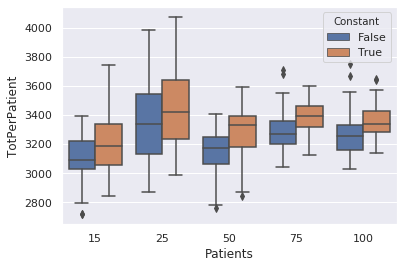

In [10]:
sns.boxplot(x="Patients",y="TotPerPatient",hue="Constant",data=df)

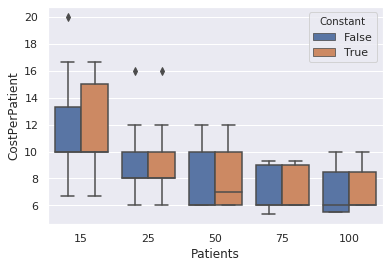

In [11]:
sns.boxplot(x="Patients",y="CostPerPatient",hue="Constant",data=df[df["nskills"]==1])

In [12]:
df["filename"].str.replace("./new_Instances/HHC_"," ").spl


AttributeError: 'Series' object has no attribute 'spl'

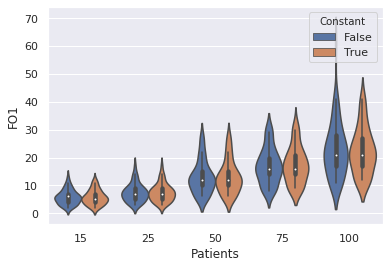

In [14]:
sns.violinplot(x="Patients",y="FO1",hue="Constant",data=df)

In [15]:
sns.boxplot(x="Patients",y="TotalTime",hue="Constant",data=df)

ValueError: Could not interpret input 'TotalTime'

In [31]:
#Balancing=pd.concat([pd.read_csv("TablaAgosto2.csv"),pd.read_csv("TablaAgosto3.csv")])
Balancing=pd.read_csv("TablaAgosto.csv")
Balancing.columns=["filename","Zmin","Zmax","FO2","Runtime"]
Balancing["Zmax/Zmin"]=Balancing["Zmax"]/Balancing["Zmin"]
Balancing

,filename,Zmin,Zmax,FO2,Runtime,Zmax/Zmin
0,./new_Instances/HHC_15_1.csv,14754,15183,44948,2.084437,1.029077
1,./new_Instances/HHC_15_2.csv,24112,24137,48249,0.703264,1.001037
2,./new_Instances/HHC_15_3.csv,14910,15344,45272,3.543247,1.029108
3,./new_Instances/HHC_15_4.csv,16517,16742,49924,2.811300,1.013622
4,./new_Instances/HHC_15_5.csv,23305,23959,47264,0.295232,1.028063
5,./new_Instances/HHC_25_1.csv,24913,25733,75710,12.962165,1.032915
6,./new_Instances/HHC_25_2.csv,28500,29287,87062,3.061257,1.027614
7,./new_Instances/HHC_25_3.csv,23056,23196,92519,441.032363,1.006072
8,./new_Instances/HHC_25_4.csv,21722,21841,87150,485.894034,1.005478
9,./new_Instances/HHC_25_5.csv,27556,27615,82762,3.918053,1.002141


In [83]:
Dimensioning=pd.concat([pd.DataFrame(pd.read_csv("TablaResultados_Fase_I.csv")),pd.DataFrame(pd.read_csv("TablaResultados_Fase_I_100.csv"))])
Dimensioning=pd.read_csv("TablaResultados.csv")

In [84]:
Dimensioning["Patients"]=Dimensioning["filename"].str.replace("./new_Instances/HHC_"," ").str.replace(".csv","")
Dimensioning["Patients"]=Dimensioning["Patients"].str.split("_", expand = True)
Dimensioning["Patients"]=Dimensioning["Patients"].apply(lambda x: int(x))
Dimensioning

,Unnamed: 0,filename,Constant,n_visits,nskills,Runtime,FO1,FO2,P1,P2,P3,Zmax,Zmin,Patients
0,0,./new_Instances/HHC_15_1.csv,True,1,1,0.0,5.0,44142.202277,5,0,0,12550.970749,900.000000,15
1,1,./new_Instances/HHC_15_1.csv,True,1,2,0.0,7.0,45592.863450,3,2,0,17027.612334,900.000000,15
2,2,./new_Instances/HHC_15_1.csv,True,1,3,0.0,8.0,45592.863450,3,1,1,17027.612334,900.000000,15
3,3,./new_Instances/HHC_15_1.csv,True,2,1,0.0,3.0,46687.022102,3,0,0,17050.559290,12698.175277,15
4,4,./new_Instances/HHC_15_1.csv,True,2,2,0.0,5.0,47631.414590,1,2,0,18050.750544,12919.128324,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,445,./new_Instances/HHC_100_5.csv,False,2,2,0.0,20.0,322014.000000,4,8,0,30125.000000,24242.000000,100
446,446,./new_Instances/HHC_100_5.csv,False,2,3,0.0,25.0,328853.000000,4,3,5,30514.000000,22830.000000,100
447,447,./new_Instances/HHC_100_5.csv,False,3,1,0.0,11.0,314322.000000,11,0,0,33141.000000,25712.000000,100
448,448,./new_Instances/HHC_100_5.csv,False,3,2,0.0,61.0,333415.000000,5,28,0,23036.000000,900.000000,100


In [85]:
#new=Dimensioning[["Patients","Constant","Runtime","Zmax","Zmin","FO1"]]
new=Dimensioning.copy()
new["Zmax/Zmin"]=new["Zmax"]/new["Zmin"]
new["FO1/Patients"]=new["FO1"]/new["Patients"]*50
new["Constant"]=new["Constant"].apply(lambda x: "Constant" if x else "Varying")
new=new.rename(columns={"Constant": "Travel Time"})
new

,Unnamed: 0,filename,Travel Time,n_visits,nskills,Runtime,FO1,FO2,P1,P2,P3,Zmax,Zmin,Patients,Zmax/Zmin,FO1/Patients
0,0,./new_Instances/HHC_15_1.csv,Constant,1,1,0.0,5.0,44142.202277,5,0,0,12550.970749,900.000000,15,13.945523,16.666667
1,1,./new_Instances/HHC_15_1.csv,Constant,1,2,0.0,7.0,45592.863450,3,2,0,17027.612334,900.000000,15,18.919569,23.333333
2,2,./new_Instances/HHC_15_1.csv,Constant,1,3,0.0,8.0,45592.863450,3,1,1,17027.612334,900.000000,15,18.919569,26.666667
3,3,./new_Instances/HHC_15_1.csv,Constant,2,1,0.0,3.0,46687.022102,3,0,0,17050.559290,12698.175277,15,1.342757,10.000000
4,4,./new_Instances/HHC_15_1.csv,Constant,2,2,0.0,5.0,47631.414590,1,2,0,18050.750544,12919.128324,15,1.397211,16.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,445,./new_Instances/HHC_100_5.csv,Varying,2,2,0.0,20.0,322014.000000,4,8,0,30125.000000,24242.000000,100,1.242678,10.000000
446,446,./new_Instances/HHC_100_5.csv,Varying,2,3,0.0,25.0,328853.000000,4,3,5,30514.000000,22830.000000,100,1.336575,12.500000
447,447,./new_Instances/HHC_100_5.csv,Varying,3,1,0.0,11.0,314322.000000,11,0,0,33141.000000,25712.000000,100,1.288931,5.500000
448,448,./new_Instances/HHC_100_5.csv,Varying,3,2,0.0,61.0,333415.000000,5,28,0,23036.000000,900.000000,100,25.595556,30.500000


In [86]:
pd.DataFrame(new[new.Runtime<3500].pivot_table(index=['Patients',"n_visits"], columns='nskills', values='Runtime',aggfunc=np.mean)).round(2)#.to_latex("Tab1.tex",multicolumn = True, multirow = True)

nskills              1    2    3
Patients n_visits               
15       1         0.0  0.0  0.0
         2         0.0  0.0  0.0
         3         0.0  0.0  0.0
25       1         0.0  0.0  0.0
         2         0.0  0.0  0.0
         3         0.0  0.0  0.0
50       1         0.0  0.0  0.0
         2         0.0  0.0  0.0
         3         0.0  0.0  0.0
75       1         0.0  0.0  0.0
         2         0.0  0.0  0.0
         3         0.0  0.0  0.0
100      1         0.0  0.0  0.0
         2         0.0  0.0  0.0
         3         0.0  0.0  0.0

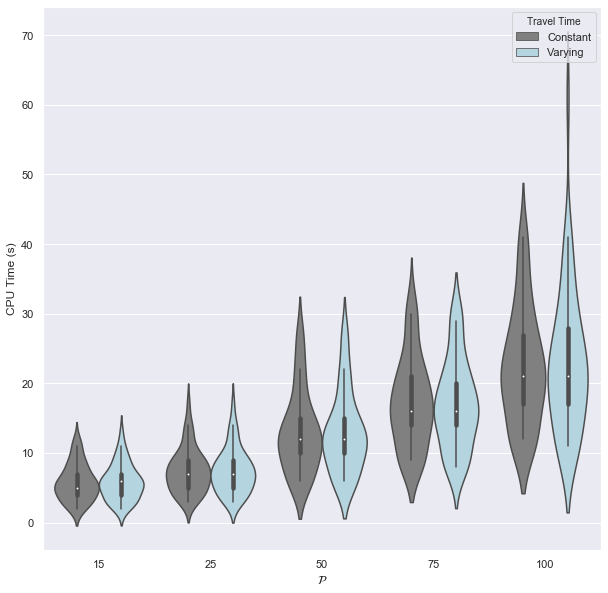

In [36]:
plt.figure(figsize=(10,10))
ax =sns.violinplot(x="Patients",y="FO1",hue="Travel Time",data=new[new.Runtime<3000],palette=['grey', 'lightblue'])
ax.set(xlabel=r'$\cal P$', ylabel='CPU Time (s)')
plt.savefig("MyFig_1.png")

In [87]:
new

,Unnamed: 0,filename,Travel Time,n_visits,nskills,Runtime,FO1,FO2,P1,P2,P3,Zmax,Zmin,Patients,Zmax/Zmin,FO1/Patients
0,0,./new_Instances/HHC_15_1.csv,Constant,1,1,0.0,5.0,44142.202277,5,0,0,12550.970749,900.000000,15,13.945523,16.666667
1,1,./new_Instances/HHC_15_1.csv,Constant,1,2,0.0,7.0,45592.863450,3,2,0,17027.612334,900.000000,15,18.919569,23.333333
2,2,./new_Instances/HHC_15_1.csv,Constant,1,3,0.0,8.0,45592.863450,3,1,1,17027.612334,900.000000,15,18.919569,26.666667
3,3,./new_Instances/HHC_15_1.csv,Constant,2,1,0.0,3.0,46687.022102,3,0,0,17050.559290,12698.175277,15,1.342757,10.000000
4,4,./new_Instances/HHC_15_1.csv,Constant,2,2,0.0,5.0,47631.414590,1,2,0,18050.750544,12919.128324,15,1.397211,16.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,445,./new_Instances/HHC_100_5.csv,Varying,2,2,0.0,20.0,322014.000000,4,8,0,30125.000000,24242.000000,100,1.242678,10.000000
446,446,./new_Instances/HHC_100_5.csv,Varying,2,3,0.0,25.0,328853.000000,4,3,5,30514.000000,22830.000000,100,1.336575,12.500000
447,447,./new_Instances/HHC_100_5.csv,Varying,3,1,0.0,11.0,314322.000000,11,0,0,33141.000000,25712.000000,100,1.288931,5.500000
448,448,./new_Instances/HHC_100_5.csv,Varying,3,2,0.0,61.0,333415.000000,5,28,0,23036.000000,900.000000,100,25.595556,30.500000


In [88]:

#new=new[["Patients","Constant","n_visits","nskills","Runtime","Zmax","Zmin","FO1"]]
new["Zmax/Zmin"]=new["Zmax"]/new["Zmin"]
new["FO1/Patients"]=new["FO1"]/new["Patients"]*50
new=new.rename(columns={"Constant": "Travel Time"})
pd.DataFrame(new.pivot_table(index=['Patients',"n_visits"], columns='Travel Time', values='FO1',aggfunc=np.mean)).round(2)#.to_latex("Tab2.tex",multicolumn = True, multirow = True)

Travel Time        Constant  Varying
Patients n_visits                   
15       1             7.93     7.80
         2             5.27     5.27
         3             4.27     4.53
25       1            10.07    10.07
         2             6.67     6.67
         3             5.80     5.67
50       1            18.33    18.20
         2            11.00    10.87
         3             9.87     9.80
75       1            22.47    22.20
         2            15.27    14.87
         3            14.27    14.13
100      1            29.20    29.13
         2            19.47    19.27
         3            18.73    20.93

,Unnamed: 0,filename,Travel Time,n_visits,nskills,Runtime,FO1,FO2,P1,P2,P3,Zmax,Zmin,Patients,Zmax/Zmin,FO1/Patients
0,0,./new_Instances/HHC_15_1.csv,Constant,1,1,0.0,5.0,44142.202277,5,0,0,12550.970749,900.000000,15,13.945523,16.666667
1,1,./new_Instances/HHC_15_1.csv,Constant,1,2,0.0,7.0,45592.863450,3,2,0,17027.612334,900.000000,15,18.919569,23.333333
2,2,./new_Instances/HHC_15_1.csv,Constant,1,3,0.0,8.0,45592.863450,3,1,1,17027.612334,900.000000,15,18.919569,26.666667
3,3,./new_Instances/HHC_15_1.csv,Constant,2,1,0.0,3.0,46687.022102,3,0,0,17050.559290,12698.175277,15,1.342757,10.000000
4,4,./new_Instances/HHC_15_1.csv,Constant,2,2,0.0,5.0,47631.414590,1,2,0,18050.750544,12919.128324,15,1.397211,16.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,445,./new_Instances/HHC_100_5.csv,Varying,2,2,0.0,20.0,322014.000000,4,8,0,30125.000000,24242.000000,100,1.242678,10.000000
446,446,./new_Instances/HHC_100_5.csv,Varying,2,3,0.0,25.0,328853.000000,4,3,5,30514.000000,22830.000000,100,1.336575,12.500000
447,447,./new_Instances/HHC_100_5.csv,Varying,3,1,0.0,11.0,314322.000000,11,0,0,33141.000000,25712.000000,100,1.288931,5.500000
448,448,./new_Instances/HHC_100_5.csv,Varying,3,2,0.0,61.0,333415.000000,5,28,0,23036.000000,900.000000,100,25.595556,30.500000


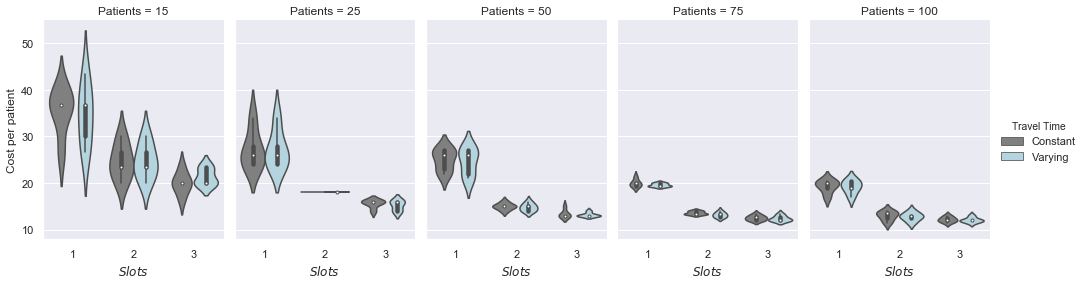

In [89]:
display(new)
g = sns.catplot(x="n_visits", y='FO1/Patients',
                hue="Travel Time", col="Patients",
                data=new[new.nskills==3], kind="violin",
                height=4, aspect=.7,palette=['grey', 'lightblue'])
g.set_axis_labels(r"$Slots$", "Cost per patient")
plt.savefig("MyFig_2.png")

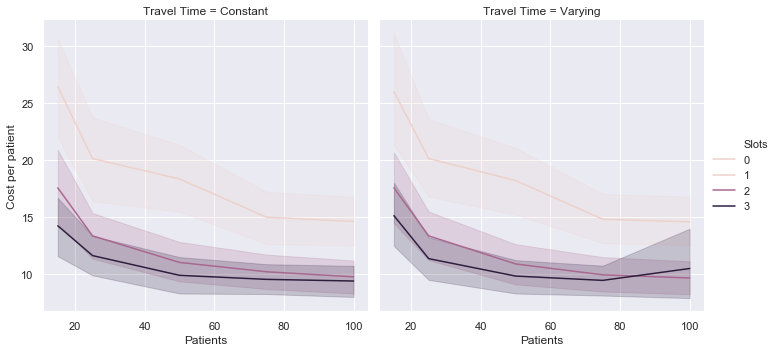

In [90]:

new.rename(columns={'nskills':'Skills',"n_visits":"Slots"},inplace=True)
g = sns.relplot(x="Patients",y='FO1/Patients',hue="Slots",col="Travel Time",kind="line",data=new)
g.set_axis_labels("Patients", "Cost per patient")
plt.savefig("MyFig_3.png")

In [41]:
new.n_visits.unique()

AttributeError: 'DataFrame' object has no attribute 'n_visits'

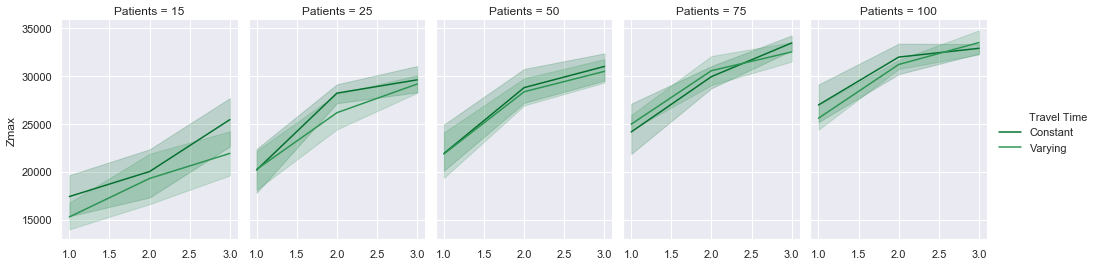

In [91]:
g = sns.relplot(x="Slots", y="Zmax",
                hue="Travel Time", col="Patients",
                data=new[new.Skills==3], kind="line",
                height=4, aspect=.7);
g.set_axis_labels("", "Zmax")
plt.savefig("MyFig_4.png")

In [92]:
sns.lmplot(x="Patients",y='FO1/Patients',hue="n_visits",data=new[~df.Constant])

AttributeError: 'DataFrame' object has no attribute 'Constant'

In [93]:
sns.lmplot(x="Patients",y="FO1",hue="n_visits",data=Dimensioning[~df.Constant==False])

AttributeError: 'DataFrame' object has no attribute 'Constant'

In [94]:
sns.lmplot(x="Patients",y="FO1",hue="n_visits",data=Dimensioning[df.Constant])

AttributeError: 'DataFrame' object has no attribute 'Constant'

In [95]:
sns.lmplot(x="Patients",y="FO1",hue="nskills",data=Dimensioning[df.Constant])

AttributeError: 'DataFrame' object has no attribute 'Constant'

In [96]:
Balancing

,filename,Zmin,Zmax,FO2,Runtime,Zmax/Zmin,Problem
0,./new_Instances/HHC_15_1.csv,14754,15183,44948,2.084437,1.029077,Balancing
1,./new_Instances/HHC_15_2.csv,24112,24137,48249,0.703264,1.001037,Balancing
2,./new_Instances/HHC_15_3.csv,14910,15344,45272,3.543247,1.029108,Balancing
3,./new_Instances/HHC_15_4.csv,16517,16742,49924,2.811300,1.013622,Balancing
4,./new_Instances/HHC_15_5.csv,23305,23959,47264,0.295232,1.028063,Balancing
5,./new_Instances/HHC_25_1.csv,24913,25733,75710,12.962165,1.032915,Balancing
6,./new_Instances/HHC_25_2.csv,28500,29287,87062,3.061257,1.027614,Balancing
7,./new_Instances/HHC_25_3.csv,23056,23196,92519,441.032363,1.006072,Balancing
8,./new_Instances/HHC_25_4.csv,21722,21841,87150,485.894034,1.005478,Balancing
9,./new_Instances/HHC_25_5.csv,27556,27615,82762,3.918053,1.002141,Balancing


In [58]:
ojo=pd.DataFrame(pd.read_csv("TablaResultados_Fase_I_100.csv"))
ojo[(ojo["n_visits"]==3) & (ojo["nskills"]==1) & ~ojo["Constant"]]

,Unnamed: 0,filename,Constant,n_visits,nskills,Runtime,FO1,P1,P2,P3,Zmax,Zmin
15,15,./new_Instances/HHC_100_1.csv,False,3,1,1.318035,11.0,11,0,0,33595.0,27483.0
33,33,./new_Instances/HHC_100_2.csv,False,3,1,1.087002,11.0,11,0,0,33894.0,30318.0
51,51,./new_Instances/HHC_100_3.csv,False,3,1,1.089001,11.0,11,0,0,33501.0,28792.0
69,69,./new_Instances/HHC_100_4.csv,False,3,1,1.759016,11.0,11,0,0,32652.0,28680.0
87,87,./new_Instances/HHC_100_5.csv,False,3,1,1.325949,11.0,11,0,0,34649.0,23385.0


In [97]:
test=pd.DataFrame(pd.read_csv("TablaResultados_nueva.csv"))
test=test[(~test["Constant"]) & (test.n_visits==3) & (test.nskills==1)]
test["Zmax/Zmin"]=test["Zmax"]/test["Zmin"]
#((np.mean(test["Zmax/Zmin"])-np.mean(Balancing["Zmax/Zmin"])))/np.mean(Balancing["Zmax/Zmin"])

In [98]:
test=test[["filename","Runtime","FO2","Zmax","Zmin","Zmax/Zmin"]]
test["Problem"]="Dimensioning"
test.rename(columns={"FO2": "FO1"})

,filename,Runtime,FO1,Zmax,Zmin,Zmax/Zmin,Problem
15,./new_Instances/HHC_15_1.csv,0.147430,44859.000000,15740.0,14521.0,1.083947,Dimensioning
33,./new_Instances/HHC_15_2.csv,0.209995,47011.000000,25311.0,21700.0,1.166406,Dimensioning
51,./new_Instances/HHC_15_3.csv,0.099901,44222.000000,16526.0,13226.0,1.249509,Dimensioning
69,./new_Instances/HHC_15_4.csv,0.103895,49214.000000,18081.0,13786.0,1.311548,Dimensioning
87,./new_Instances/HHC_15_5.csv,0.103313,46857.000000,24692.0,22165.0,1.114009,Dimensioning
105,./new_Instances/HHC_25_1.csv,0.302299,75128.999795,30247.0,21154.0,1.429848,Dimensioning
123,./new_Instances/HHC_25_2.csv,0.145514,86234.000000,30977.0,25812.0,1.200101,Dimensioning
141,./new_Instances/HHC_25_3.csv,0.079645,91123.000000,28354.0,17515.0,1.618841,Dimensioning
159,./new_Instances/HHC_25_4.csv,0.078648,85216.000000,26884.0,14445.0,1.861128,Dimensioning
177,./new_Instances/HHC_25_5.csv,0.109564,81328.000000,28545.0,25808.0,1.106052,Dimensioning


In [99]:
Balancing=Balancing.rename(columns={"unnamed:0:": "Problem"})
Balancing["Problem"]="Balancing"
Balancing.rename(columns={"FO2": "FO1"})
Balancing

,filename,Zmin,Zmax,FO2,Runtime,Zmax/Zmin,Problem
0,./new_Instances/HHC_15_1.csv,14754,15183,44948,2.084437,1.029077,Balancing
1,./new_Instances/HHC_15_2.csv,24112,24137,48249,0.703264,1.001037,Balancing
2,./new_Instances/HHC_15_3.csv,14910,15344,45272,3.543247,1.029108,Balancing
3,./new_Instances/HHC_15_4.csv,16517,16742,49924,2.811300,1.013622,Balancing
4,./new_Instances/HHC_15_5.csv,23305,23959,47264,0.295232,1.028063,Balancing
5,./new_Instances/HHC_25_1.csv,24913,25733,75710,12.962165,1.032915,Balancing
6,./new_Instances/HHC_25_2.csv,28500,29287,87062,3.061257,1.027614,Balancing
7,./new_Instances/HHC_25_3.csv,23056,23196,92519,441.032363,1.006072,Balancing
8,./new_Instances/HHC_25_4.csv,21722,21841,87150,485.894034,1.005478,Balancing
9,./new_Instances/HHC_25_5.csv,27556,27615,82762,3.918053,1.002141,Balancing


In [100]:
final=pd.concat([Balancing,test])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [101]:
final["Patients"]=final.filename.str.replace("./new_Instances/HHC_"," ").str.replace(".csv","")
final["Patients"]=final.Patients.str.split("_", expand = True)

In [102]:
final["Zmax"],final["Zmin"]=final["Zmax"]/3600,final["Zmin"]/3600
final["FO2"]=final["FO2"]/3600
final.reset_index()
final["Patients"]=final["Patients"].apply(lambda x: int(x) )
final.sort_values(by="Patients")

,FO2,Problem,Runtime,Zmax,Zmax/Zmin,Zmin,filename,Patients
0,12.485556,Balancing,2.084437,4.217500,1.029077,4.098333,./new_Instances/HHC_15_1.csv,15
1,13.402500,Balancing,0.703264,6.704722,1.001037,6.697778,./new_Instances/HHC_15_2.csv,15
2,12.575556,Balancing,3.543247,4.262222,1.029108,4.141667,./new_Instances/HHC_15_3.csv,15
3,13.867778,Balancing,2.811300,4.650556,1.013622,4.588056,./new_Instances/HHC_15_4.csv,15
4,13.128889,Balancing,0.295232,6.655278,1.028063,6.473611,./new_Instances/HHC_15_5.csv,15
87,13.015833,Dimensioning,0.103313,6.858889,1.114009,6.156944,./new_Instances/HHC_15_5.csv,15
69,13.670556,Dimensioning,0.103895,5.022500,1.311548,3.829444,./new_Instances/HHC_15_4.csv,15
51,12.283889,Dimensioning,0.099901,4.590556,1.249509,3.673889,./new_Instances/HHC_15_3.csv,15
33,13.058611,Dimensioning,0.209995,7.030833,1.166406,6.027778,./new_Instances/HHC_15_2.csv,15
15,12.460833,Dimensioning,0.147430,4.372222,1.083947,4.033611,./new_Instances/HHC_15_1.csv,15


In [103]:
pd.DataFrame(final.pivot_table(index=['filename',"Patients"], columns='Problem', values=["Zmax","Zmin","Zmax/Zmin","FO2"],aggfunc=np.mean)).round(2)#.to_latex("Tab3.tex",multicolumn = True, multirow = True)

FO2                   Zmax  \
Problem                                Balancing Dimensioning Balancing   
filename                      Patients                                    
./new_Instances/HHC_100_1.csv 100          81.42          NaN      8.63   
./new_Instances/HHC_100_2.csv 100          85.06          NaN      8.12   
./new_Instances/HHC_100_3.csv 100          90.19          NaN      8.09   
./new_Instances/HHC_100_4.csv 100          87.49          NaN      7.91   
./new_Instances/HHC_15_1.csv  15           12.49        12.46      4.22   
./new_Instances/HHC_15_2.csv  15           13.40        13.06      6.70   
./new_Instances/HHC_15_3.csv  15           12.58        12.28      4.26   
./new_Instances/HHC_15_4.csv  15           13.87        13.67      4.65   
./new_Instances/HHC_15_5.csv  15           13.13        13.02      6.66   
./new_Instances/HHC_25_1.csv  25           21.03        20.87      7.15   
./new_Instances/HHC_25_2.csv  25           24.18        23.95      8.14   
./new_Instances/HHC_25_3.csv  25           25.70        25.31      6.44   
./new_Instances/HHC_25_4.csv  25           24.21        23.67      6.07   
./new_Instances/HHC_25_5.csv  25           22.99        22.59      7.67   
./new_Instances/HHC_50_1.csv  50           45.34        44.73      7.64   
./new_Instances/HHC_50_2.csv  50           41.03        40.43      6.94   
./new_Instances/HHC_50_3.csv  50           43.61        42.59      7.32   
./new_Instances/HHC_50_4.csv  50           44.39        44.09      7.52   
./new_Instances/HHC_50_5.csv  50           45.40        44.89      7.60   
./new_Instances/HHC_75_1.csv  75           67.81        67.25      7.65   
./new_Instances/HHC_75_2.csv  75             NaN        64.76       NaN   
./new_Instances/HHC_75_3.csv  75           69.04        68.22      7.82   
./new_Instances/HHC_75_4.csv  75           67.64        66.66      7.72   
./new_Instances/HHC_75_5.csv  75           66.78        65.36      7.68   

                                                    Zmax/Zmin               \
Problem                                Dimensioning Balancing Dimensioning   
filename                      Patients                                       
./new_Instances/HHC_100_1.csv 100               NaN      1.40          NaN   
./new_Instances/HHC_100_2.csv 100               NaN      1.10          NaN   
./new_Instances/HHC_100_3.csv 100               NaN      1.31          NaN   
./new_Instances/HHC_100_4.csv 100               NaN      1.27          NaN   
./new_Instances/HHC_15_1.csv  15               4.37      1.03         1.08   
./new_Instances/HHC_15_2.csv  15               7.03      1.00         1.17   
./new_Instances/HHC_15_3.csv  15               4.59      1.03         1.25   
./new_Instances/HHC_15_4.csv  15               5.02      1.01         1.31   
./new_Instances/HHC_15_5.csv  15               6.86      1.03         1.11   
./new_Instances/HHC_25_1.csv  25               8.40      1.03         1.43   
./new_Instances/HHC_25_2.csv  25               8.60      1.03         1.20   
./new_Instances/HHC_25_3.csv  25               7.88      1.01         1.62   
./new_Instances/HHC_25_4.csv  25               7.47      1.01         1.86   
./new_Instances/HHC_25_5.csv  25               7.93      1.00         1.11   
./new_Instances/HHC_50_1.csv  50               7.96      1.05         1.16   
./new_Instances/HHC_50_2.csv  50               7.97      1.06         1.42   
./new_Instances/HHC_50_3.csv  50               7.67      1.03         1.23   
./new_Instances/HHC_50_4.csv  50               8.60      1.05         1.41   
./new_Instances/HHC_50_5.csv  50               8.42      1.01         1.30   
./new_Instances/HHC_75_1.csv  75               8.84      1.04         1.33   
./new_Instances/HHC_75_2.csv  75               8.63       NaN         1.21   
./new_Instances/HHC_75_3.csv  75               8.36      1.06         1.24   
./new_Instances/HHC_75_4.csv  75               9.01      1.08        

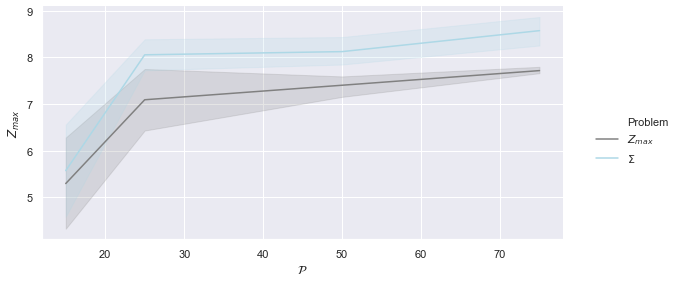

In [121]:

g = sns.relplot(x="Patients", y="Zmax",
                hue="Problem",
                data=final[final.Patients<100].sort_values(by="Patients"), kind="line",
                height=4, aspect=2,palette=['grey', 'lightblue']);
g.set_axis_labels(r'$\cal P$', r"$Z_{max}$")

g._legend.texts[1].set_text(r'$Z_{max}$')
g._legend.texts[2].set_text(r'$\Sigma$')

plt.savefig("MyFig_4.png")

In [111]:
g._legend.texts

[Text(0, 0, '$Z_{max}$'), Text(0, 0, '$\\Sigma$'), Text(0, 0, 'Dimensioning')]

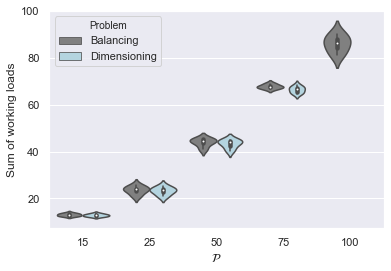

In [123]:
g=sns.violinplot(x="Patients", y="FO2",
                hue="Problem",
                data=final,palette=['grey', 'lightblue']).set(
    xlabel=r'$\cal P$', 
    ylabel='Sum of working loads'
);
plt.savefig("MyFig_6.png")